# Data Analysis

In [1]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
import tqdm
import matplotlib.pyplot as plt
import random

%matplotlib inline

### Data Import

In [2]:
def txt_to_matrix(filename, line_skip = 5):
    f = open (filename, 'r')
    
    # Lineskip, cleaning, conversion
    data = f.readlines()[line_skip:]
    
    data = np.asarray(
        [l.replace("\n", "").split() for l in data]
    ).astype(np.float32)
    
    data[data > 100] = 0
    
    return data

In [3]:
def get_time_step(root, index):
    
    dep = txt_to_matrix(root + 'decoded-' + index + '.DEP')
    vvx = txt_to_matrix(root + 'decoded-' + index + '.VVX')
    vvy = txt_to_matrix(root + 'decoded-' + index + '.VVY')

    return np.array([dep, vvx, vvy])

def get_dep_time_step(root, index):
    
    dep = txt_to_matrix(root + 'mini-decoded-' + index + '.DEP')

    return np.array([dep])

In [4]:
rootdir = '../datasets/530-9m1s/'
timesteps = []
ignore = [".DS_Store", ".", ".."]

x = 0
offset = 0
ceiling = 530

# Read all dirs and process them
for path in tqdm.tqdm(range(ceiling - offset)):
    
    # Processing
    file = rootdir
    timesteps.append(
        get_dep_time_step(
            file, ("{:04d}".format(x + offset))
        )
    )
    x += 1
        
timesteps = np.asarray(timesteps).astype(np.float32)

100%|██████████| 530/530 [00:48<00:00, 10.86it/s]


### Helper functions

In [5]:
def scan_wet_areas(timesteps, threshold = 0.1):
    areas = []
    for j in  range(timesteps.shape[2]):
        for i in  range(timesteps.shape[3]):
            if np.sum(timesteps[:, 0, j, i]) > threshold:
                areas.append((j, i))
    return areas

### Analisi Univariata

In [6]:
def box_plot_timesteps(data, index, label):
    
    s1 = data[10][index].flatten()
    s2 = data[20][index].flatten()
    s3 = data[30][index].flatten()
    s4 = data[40][index].flatten()
    
    print("Media: \t\t\t{}".format(np.mean(data[:][index])))
    print("Deviazione std: \t{}".format(np.std(data[:][index])))

    fig, axs = plt.subplots(2, 2)
    fig.suptitle(label)

    axs[0, 0].boxplot(s1)
    axs[0, 0].set_title('t = 300\'')

    axs[0, 1].boxplot(s2)
    axs[0, 1].set_title('t = 600\'')

    axs[1, 0].boxplot(s3)
    axs[1, 0].set_title('t = 900\'')

    axs[1, 1].boxplot(s4)
    axs[1, 1].set_title('t = 1200\'')

    for ax in axs.flat:
        ax.label_outer()

#### Variabile 1: DEP - profonditá del fluido

In [7]:
dep = timesteps[int(timesteps.shape[0]/2), 0].flatten()

Max: 0.16682599484920502
Min: 0.0
Mean: 0.0828869491815567


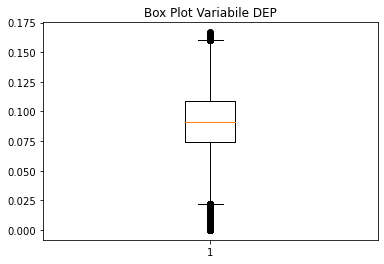

In [8]:
plt.title("Box Plot Variabile DEP")
_ = plt.boxplot(np.unique(dep))
print("Max: {}\nMin: {}\nMean: {}".format(np.max(dep), np.min(dep), np.mean(dep)))

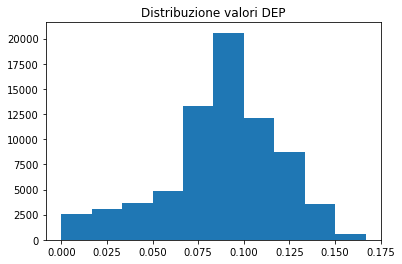

In [9]:
plt.title("Distribuzione valori DEP")
_ = plt.hist(np.unique(dep))

In [10]:
# box_plot_timesteps(timesteps, 2, "Velocitá flussi Y")

### Analisi Bivariata

#### Plot progressione temporale dei dati

In [11]:
def plot_map_timesteps(data, index, label):
    
    fig, axs = plt.subplots(2, 2)
    fig.suptitle(label)
    interval = int(data.shape[0]/200)

    axs[0, 0].matshow(data[interval][index])
    axs[0, 0].set_title('frame {}'.format(interval))

    axs[0, 1].matshow(data[2*interval][index])
    axs[0, 1].set_title('frame {}'.format(2*interval))

    axs[1, 0].matshow(data[3*interval][index])
    axs[1, 0].set_title('frame {}'.format(3*interval))

    axs[1, 1].matshow(data[4*interval][index])
    axs[1, 1].set_title('frame {}'.format(4*interval))
            
    fig.subplots_adjust(hspace=0.5)
    
    for ax in axs.flat:
        ax.set_yticklabels([])
        ax.set_xticklabels([])

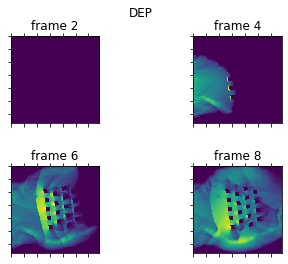

In [12]:
plot_map_timesteps(timesteps, 0, "DEP")


#### 3D Close-up

In [13]:
def save_frames(timesteps, frames, size=20, angle=-45):

    fig = plt.figure(figsize=(16, 6))
    ax1 = fig.add_subplot(121, projection='3d')

    centerx = int(timesteps.shape[2]/2)
    centery = int(timesteps.shape[3]/2)

    # Axis data
    _x = np.arange(size)
    _y = np.arange(size)
    _xx, _yy = np.meshgrid(_x, _y)
    x, y = _xx.ravel(), _yy.ravel()

    ax1.view_init(30, angle)

    # Depths as heights
    for frame in tqdm.tqdm(range(frames)):
        top = timesteps[frame, 0, int(centerx-size/2):int(centerx+size/2), int(centery-size/2):int(centery+size/2)].flatten()
        bottom = np.zeros_like(top)
        width = depth = 1

        ax1.view_init(30, angle)
        ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='c')
        ax1.set_title('{}x{}'.format(size, size))

        plt.savefig('{}.png'.format(frame))


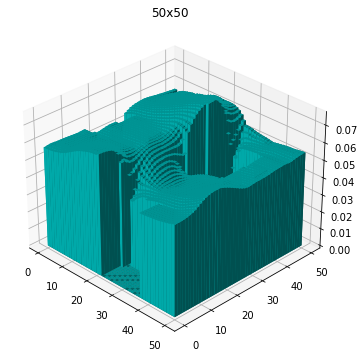

In [14]:
import matplotlib.patches as patches

# setup the figure and axes
fig = plt.figure(figsize=(16, 6))
ax1 = fig.add_subplot(121, projection='3d')

size = 50
centerx = int(timesteps.shape[2]/2)
centery = int(timesteps.shape[3]/2)

# Axis data
_x = np.arange(size)
_y = np.arange(size)
_xx, _yy = np.meshgrid(_x, _y)
x, y = _xx.ravel(), _yy.ravel()


# Depths as heights
top = timesteps[50, 0, int(centerx-size/2):int(centerx+size/2), int(centery-size/2):int(centery+size/2)].flatten()
bottom = np.zeros_like(top)
width = depth = 1

ax1.view_init(30, -45)
ax1.bar3d(x, y, bottom, width, depth, top, shade=True, color='c')
ax1.set_title('{}x{}'.format(size, size))

plt.show()

In [15]:
# plot_map_timesteps(timesteps, 1, "VVX")

In [16]:
# plot_map_timesteps(timesteps, 1, "VVY")

#### Correlazione tra 2 celle del fluido

In [17]:
def random_pixels_correlation(timesteps):
    
    # Pick random pixels that are not dry
    pixels = scan_wet_areas(timesteps)
    distance = int(len(pixels)/2)
    rnd = random.choice(list(range(len(pixels) - distance)))

    p1, p2 = pixels[rnd], pixels[rnd + distance]

    pixel_1 = timesteps[:, 0, p1[0], p1[1]]
    pixel_2 = timesteps[:, 0, p2[0], p2[1]]

    w = 20
    h = 20
    x_s = int(timesteps.shape[2]/2)+ 61 - w
    x_e = int(timesteps.shape[2]/2)+ 61
    y_s = int(timesteps.shape[3] - 1) - h
    y_e = int(timesteps.shape[3] - 1)

    # Plot 1
    plt.title("Punti random per confronto (t = 0)")
    plt.imshow(timesteps[timesteps.shape[0]-1, 0], interpolation='nearest')
    plt.scatter(list(p1), list(p2), color='red', s=40)    
    
    plt.show()

    # Stats
    print("Analisi punti a scelta randomica: \nA({}, {})\nB({}, {})\n".format(p1[0], p1[1], p2[0], p2[1]))
    print("Correlazione A e B: \n{}".format(np.corrcoef(pixel_1, pixel_2)))

    # Plot 2
    plt.title("Correlazione A(x) - B(y) [altezza fluido]")
    chosen = pixel_1

    ax = plt.gca()
    ax.margins(x=-0.4, y=-0.4)

    #plt.scatter(np.arange(chosen.shape[0]), chosen)
    plt.scatter(pixel_1, pixel_2)
    plt.show()

    # Plot 3 - A
    plt.title("Andamento flusso pixel A")
    chosen = pixel_1
    
    plt.plot(np.arange(chosen.shape[0]), chosen)
    plt.show()
    
    # Plot 3 - B
    plt.title("Andamento flusso pixel B")
    chosen = pixel_2

    plt.plot(np.arange(chosen.shape[0]), chosen)
    plt.show()

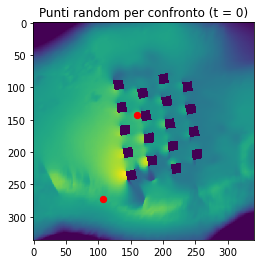

Analisi punti a scelta randomica: 
A(107, 159)
B(273, 143)

Correlazione A e B: 
[[1.         0.98129443]
 [0.98129443 1.        ]]


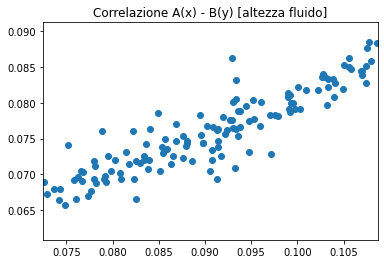

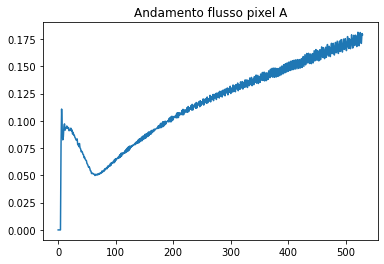

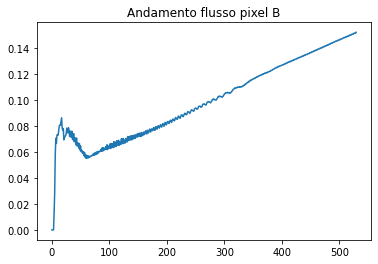

In [18]:
random_pixels_correlation(timesteps)

### Scikit PCA
Problemi PCA: come ritornare al frame ricostruito?

In [ ]:
X = np.asarray([t.flatten() for t in timesteps[:, 0]])
print("Data of shape: {}".format(X.shape))

In [33]:
from sklearn.decomposition import PCA

compression = 100
components = min(X.shape)

# create the PCA instance
pca = PCA(components)
# fit on data
pca.fit(X)

# print(pca.components_)
# print(pca.explained_variance_)

# transform data
B = pca.transform(X)

print(B[0].shape)

(530,)
